In [15]:
import torch
import torch.nn.functional as F
import math

def attention(Q, K, V):
    d_k = Q.size(-1)

    scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(d_k)
    weights = F.softmax(scores, dim=-1)
    output = torch.matmul(weights, V)

    return output, weights


In [16]:
import torch
import torch.nn.functional as F
import math

def causal_attention(Q, K, V):
    seq_len, d_k = Q.size()
    scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(d_k)
    mask = torch.triu(torch.ones(seq_len, seq_len), diagonal=1).to(Q.device)
    scores = scores.masked_fill(mask == 1, float('-inf'))
    weights = F.softmax(scores, dim=-1)
    output = torch.matmul(weights, V)
    return output, weights


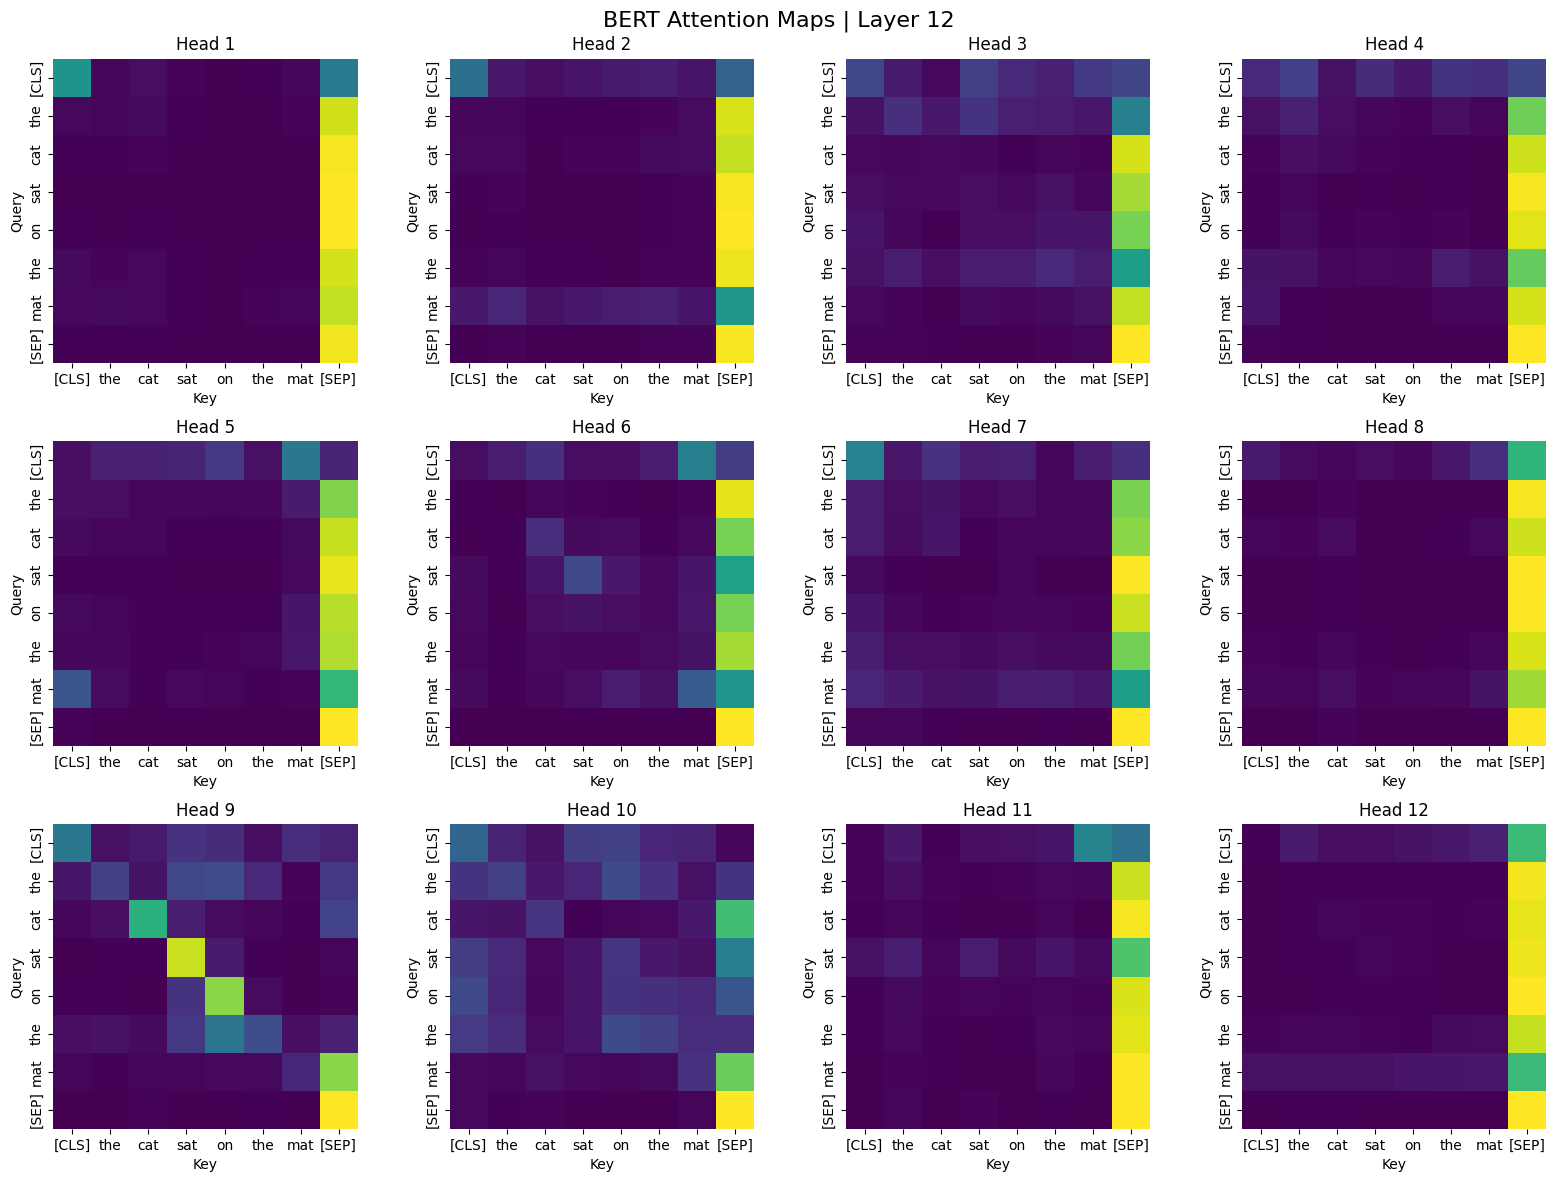

In [17]:
import torch
import math
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import BertTokenizer, BertModel
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = BertModel.from_pretrained(
    "bert-base-uncased",
    output_attentions=True
)
model.eval()
sentence = "The cat sat on the mat"
inputs = tokenizer(sentence, return_tensors="pt")
with torch.no_grad():
    outputs = model(**inputs)
attentions = outputs.attentions
tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])
def visualize_attention_layer(attentions, tokens, layer):
    num_heads = attentions[layer].size(1)

    fig, axes = plt.subplots(3, 4, figsize=(16, 12))
    axes = axes.flatten()

    for head in range(num_heads):
        attn = attentions[layer][0, head].cpu()
        sns.heatmap(
            attn,
            xticklabels=tokens,
            yticklabels=tokens,
            cmap="viridis",
            square=True,
            cbar=False,
            ax=axes[head]
        )
        axes[head].set_title(f"Head {head+1}")
        axes[head].set_xlabel("Key")
        axes[head].set_ylabel("Query")

    plt.suptitle(f"BERT Attention Maps | Layer {layer+1}", fontsize=16)
    plt.tight_layout()
    plt.show()

layer_to_visualize = 11
visualize_attention_layer(attentions, tokens, layer_to_visualize)


In [18]:
import tensorflow as tf
from tensorflow.keras import layers
# -----------------------------
# Positional Encoding Layer
# -----------------------------
class PositionalEncoding(layers.Layer):
    def __init__(self, max_len, d_model):
        super().__init__()
        self.pos_encoding = self.positional_encoding(max_len, d_model)

    def get_angles(self, pos, i, d_model):
        angle_rates = 1 / tf.pow(10000., (2 * (i//2)) / tf.cast(d_model, tf.float32))
        return pos * angle_rates

    def positional_encoding(self, max_len, d_model):
        angle_rads = self.get_angles(
            pos=tf.range(max_len)[:, tf.newaxis],
            i=tf.range(d_model)[tf.newaxis, :],
            d_model=d_model
        )

        # QUESTION : apply sin to even indices, cos to odd
        angle_rads[:, 0::2] = tf.sin(angle_rads[:, 0::2])  # even indices
        angle_rads[:, 1::2] = tf.cos(angle_rads[:, 1::2])  # odd indices

        return angle_rads[tf.newaxis, ...]

    def call(self, x):
        return x + tf.cast(self.pos_encoding[:, :tf.shape(x)[1], :], x.dtype)

In [19]:
from tensorflow.keras import layers, Model

# -----------------------------
# Transformer Encoder Block
# -----------------------------
def transformer_encoder_block(embed_dim, num_heads, ff_dim, dropout=0.1):
    inputs = layers.Input(shape=(None, embed_dim))

    # Layer Norm + Multi-Head Attention
    x = layers.LayerNormalization()(inputs)
    attention_output = layers.MultiHeadAttention(
        num_heads=num_heads,
        key_dim=embed_dim // num_heads,
        dropout=dropout
    )(x, x)
    x = layers.Add()([inputs, attention_output])  # Residual

    # Feed Forward Network
    ff = layers.LayerNormalization()(x)
    ff = layers.Dense(ff_dim, activation="relu")(ff)
    ff = layers.Dense(embed_dim)(ff)
    x = layers.Add()([x, ff])  # Residual

    return Model(inputs, x, name="TransformerEncoderBlock")

In [20]:
from tensorflow.keras import layers, Model
import tensorflow as tf

# -----------------------------
# Build the Transformer Model
# -----------------------------
def build_transformer(
        max_len=100,
        vocab_size=10000,
        embed_dim=64,
        num_heads=4,
        ff_dim=128,
        num_layers=3
    ):
    inputs = layers.Input(shape=(None,), dtype=tf.int32)

    # Token Embedding + Positional Encoding
    x = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)(inputs)
    x = PositionalEncoding(max_len, embed_dim)(x)

    # Transformer Encoder Blocks
    for _ in range(num_layers):
        x = transformer_encoder_block(embed_dim, num_heads, ff_dim)(x)

    # Classification head
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(64, activation="relu")(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)

    model = Model(inputs, outputs, name="Transformer_3Layer")
    return model


In [21]:
# -----------------------------
# Instantiate + Compile Model
# -----------------------------
model = build_transformer()

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

model.summary()


TypeError: `x` and `y` must have the same dtype, got tf.int32 != tf.float32.